<a href="https://colab.research.google.com/github/moumahan1990/retail_timeseries_forecasting/blob/master/Prophet_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [0]:
# importing data
train = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
# additional store data
store = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/store.csv",low_memory = False)

In [6]:
# Adding new features based on date
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [0]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [74]:
# remove closed stores and those with no sales
df = train[(train["Open"] != 0) & (train['Sales'] != 0)]
df['Date'] = df.index
# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1]
sales = sales[['Sales','Date','Promo']]
sales = sales.sort_index(ascending=True)
sales.head(10)

,Sales,Date,Promo
Date,,,
2013-01-02,5530,2013-01-02,0
2013-01-03,4327,2013-01-03,0
2013-01-04,4486,2013-01-04,0
2013-01-05,4997,2013-01-05,0
2013-01-07,7176,2013-01-07,1
2013-01-08,5580,2013-01-08,1
2013-01-09,5471,2013-01-09,1
2013-01-10,4892,2013-01-10,1
2013-01-11,4881,2013-01-11,1


In [83]:
# Pre Processing the data for Prophet
sales = sales.rename(columns = {'Date': 'ds','Sales': 'y'})
sales.head()

,y,ds,Promo
Date,,,
2013-01-02,5530,2013-01-02,0
2013-01-03,4327,2013-01-03,0
2013-01-04,4486,2013-01-04,0
2013-01-05,4997,2013-01-05,0
2013-01-07,7176,2013-01-07,1


In [0]:
import plotly.express as px

In [22]:
fig = px.line(sales, x='ds', y='y')
fig.show()

In [23]:
# create holiday dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [0]:
#Create train test split
sales_train= sales.head(730)
len(sales_train)
sales_train.head()
sales_test= sales.tail(50)

In [81]:
sales_train

,y,ds,Promo
Date,,,
2013-01-02,5530,2013-01-02,0
2013-01-03,4327,2013-01-03,0
2013-01-04,4486,2013-01-04,0
2013-01-05,4997,2013-01-05,0
2013-01-07,7176,2013-01-07,1
...,...,...,...
2015-05-27,4083,2015-05-27,0
2015-05-28,4111,2015-05-28,0
2015-05-29,4656,2015-05-29,0


In [75]:
# Create model seasonality_prior_scale= 0.1
model = Prophet(interval_width = 0.95, holidays = holidays, seasonality_prior_scale= 1)
model.add_regressor('Promo')
model.fit(sales_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
# predictions
# dataframe that extends into future 6 weeks 
# future_dates = my_model.make_future_dataframe(periods = 6*7)
future_dates = sales_test[['ds','Promo']]
forecast = model.predict(future_dates)
# preditions for last week
# forecast[['yhat']]

In [0]:
result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [40]:
result.head(7)

,ds,yhat,yhat_lower,yhat_upper
0,2015-06-03,4515.421887,2955.835119,6179.794863
1,2015-06-05,4720.315365,3104.166649,6340.949175
2,2015-06-06,4765.786951,3141.821563,6443.109863
3,2015-06-08,4882.483277,3241.899923,6727.811138
4,2015-06-09,4386.956328,2644.210812,6148.207073
5,2015-06-10,4294.134963,2534.559096,5865.496716
6,2015-06-11,4198.427606,2600.923444,5936.187045


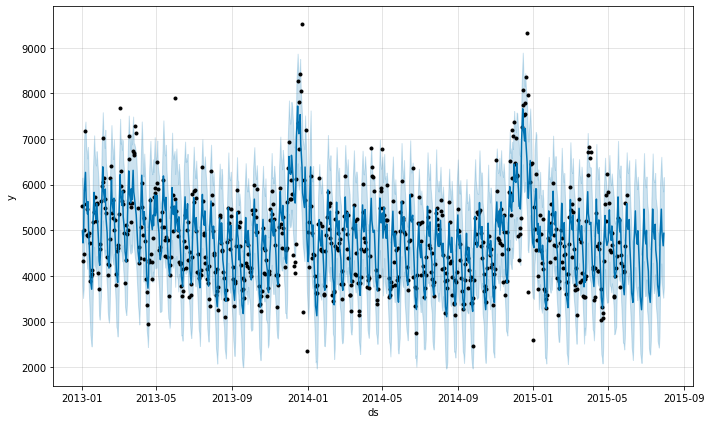

In [85]:
forecast_total = model.predict(sales[['ds','Promo']])
fig1 = model.plot(forecast_total)

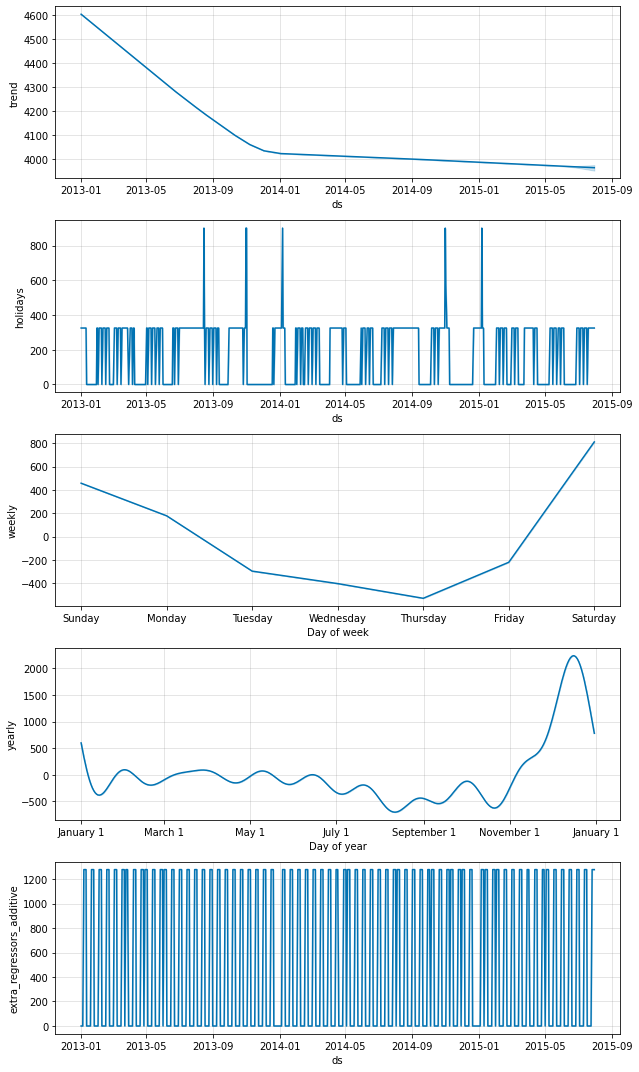

In [86]:
fig2 = model.plot_components(forecast_total)


In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
rmse = sqrt(mean_squared_error(sales_test.y, result.yhat))
print("RMSE",rmse)
print("MAE",mean_absolute_error(sales_test.y, result.yhat))
MAPE= np.mean(np.abs((sales_test.y.values - result.yhat.values) / sales_test.y)) * 100
print("MAPE",MAPE)
def MASE(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d
def smape(actual, predicted):
    # return 100/len(test) * np.sum(2 * np.abs(pred - test) / (np.abs(test) + np.abs(pred)))
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))
print("MASE",MASE(sales_train.y.values,sales_test.y.values, result.yhat.values))
print("SMAPE",smape(sales_test.y.values,result.yhat.values))

RMSE 405.7404944640041
MAE 320.70979052798134
MAPE 7.281992201364611
MASE 0.5547874967251005
SMAPE 0.07179479957317053
